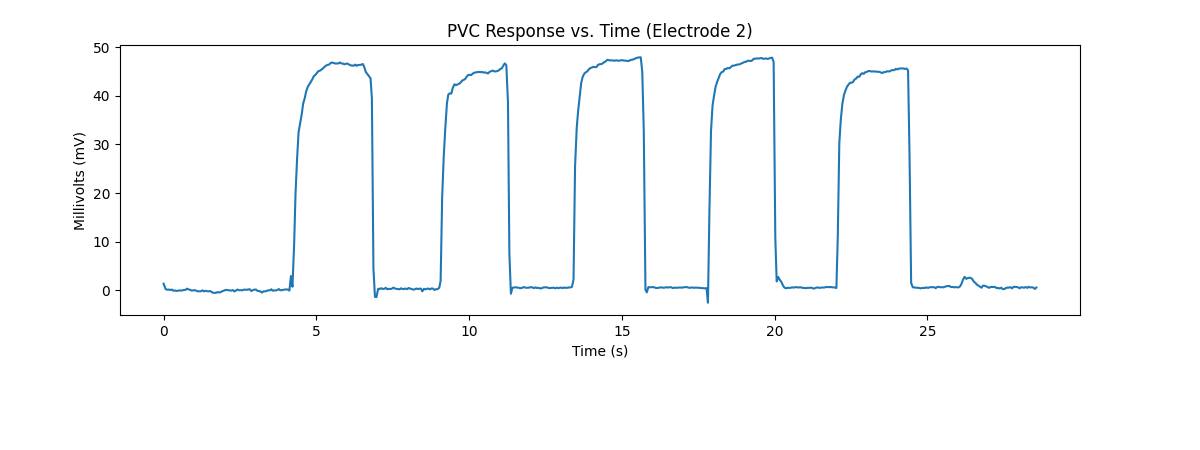

In [6]:
### Just goofin here

from operator import index
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
from scipy.optimize import curve_fit
import xlsxwriter
%matplotlib widget
from scipy import stats


### Reading the excel file
# df stands for dataframe (self-declared variable)
df = pd.read_excel(
    r"C:\Users\Home\Documents\School\Research\PVC Gel Data\defbuffer2_0113_233141.xlsx",
    # Do not read row 1 (zero index) of Excel file
    skiprows=18,
    # Read cols A:C only in Excel
    usecols="A:B",
    # The index (or x-axis)
    index_col=0,
)

df["PVC"] = df["PVC"] * 1000

# Filter PVC gel values so that it doesn't include outliers above 100mV
condition1 = df["PVC"] < 100
df.where(condition1, inplace=True)


# Interpolating dataframe and getting rid of NaN
# .sort_index() numercally sorts index and all attached data
# .bfill() fills NaN values a particular value see documentation (only one Nan value after interpolate)
df = df.sort_index().interpolate().bfill()

# Offsetting load column to disregard initial tension on load cell 
# Uses avgLoad for the first two seconds
# timeRange = df[(df.index) < 2]
# avgLoad = timeRange["Load"].mean()
# df = df - [avgLoad,0]

# Converting PVC from V to mV


# Converting Load from V to mv, then to grams (10mv = 250g Compression)
# df["Load"] = df["Load"] * 1000 * 25

### This is a dataframe that stores the range we're interested in, 
# it is populated by the user selection from the graph
dfDomain = pd.DataFrame(columns=['xmin', 'xmax'])

# Telling matplotlib we want two plots and specifying their output size
fig, (graph1) = plt.subplots(1, figsize=(12, 4.5))

# Moving the plots so they're not so close together when outputting and covering labels
plt.subplots_adjust(left=0.1, bottom=0.3, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Plotting graphs.......
# graph1.plot(df["Load"])
graph1.plot(df["PVC"])

# Labeling graphs 
# graph1.set_title("Applied Load")
graph1.set_title("PVC Response vs. Time (Electrode 2)")
# graph1.set_ylabel("Grams (g)")
graph1.set_ylabel("Millivolts (mV)")
graph1.set_xlabel("Time (s)")

# ---- Need to better understand how the functions below are defined

# This function is called everytime the SpanSelector widget is used 
def onselect_function1(min_value, max_value):
    dfDomain.loc[len(dfDomain.index)] = [min_value, max_value]
    return min_value, max_value


span2 = SpanSelector(
    graph1,
    onselect_function1,
    direction="horizontal",
    useblit=True,
    props=dict(alpha=0.5, facecolor="tab:blue"),
    interactive=True,
    drag_from_anywhere=True
)

       xmin       xmax
0  5.347484   6.002157
1  9.864724  10.748532

 Average: 45.62 mV


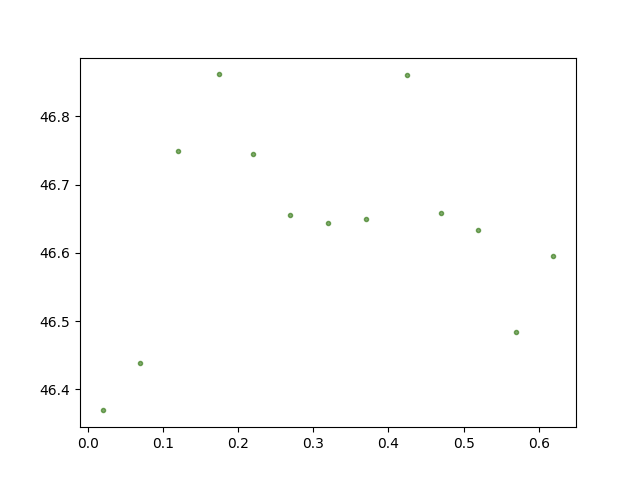

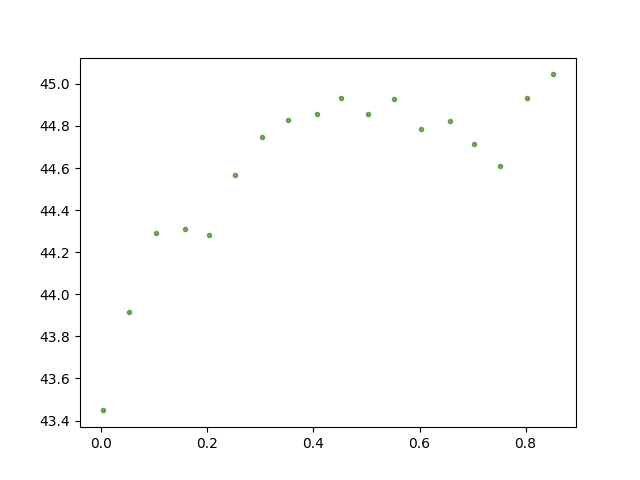

In [7]:
# 'row' in for loop always initializes at 0

# Counter used to find mean of sensing voltage
# sourcery skip: avoid-builtin-shadow
i = 0
total_PVC_mean = 0

print(dfDomain)

for row in dfDomain.index:
    # Setting xmin and xmax for each iteration from dfDomain
    xmin = dfDomain["xmin"][row]
    xmax = dfDomain["xmax"][row]
    # Manipulating data to use for exponential fit

    # The ranges selected from the graph are now cutting down the main dataframe
    range = df.PVC[(df.index > xmin) & (df.index < xmax)]
    dfGraphData = pd.DataFrame(range)
    dfGraphData["Relative Time"] = dfGraphData.index

    t = dfGraphData["Relative Time"]

    ### Reset index to 0
    dfGraphData = pd.DataFrame(range)
    dfGraphData.reset_index(inplace=True)

    # Offset so time starts @ 0
    dfGraphData = dfGraphData - [xmin, 0]

    # Scatter Plot
    fig, ax = plt.subplots(1)
    ax.scatter(
        dfGraphData["Relative Time"],
        dfGraphData["PVC"],
        alpha=0.6,
        marker=".",
        color="#2b730a",
        label="PVC",
    )

    # # Line of best fit
    # ax.plot(dfGraphData["Time"], y_fit, color="#0d1452", label="Fit")
    # ax.set_xlabel("Time (s)")
    # ax.set_ylabel("Load (g)")
    # ax.legend()
    # ax.set_title("(Graph " + str(dfDomain.index[row]+1) + ")\n" + "Load vs. Time")


    # Get the average voltage for each range and add together, find total mean after 
    # The loop finishes
  
    total_PVC_mean += dfGraphData["PVC"].mean() 
    i += 1

total_PVC_mean = total_PVC_mean / (i)
print(f"\n Average: {round(total_PVC_mean, 2)} mV" )
